In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy


In [2]:
engine = sqlalchemy.create_engine(r"sqlite:///D:\alphavantage\daily_close_adj_av.db")

In [3]:
b_df = pd.DataFrame( )
# Select stock pair (example: Goldman Sachs and Caterpillar)
stock1 = "AMZN"
stock2 = "CRM"
stocks = [ stock1 , stock2 ]
for stock in stocks :
    
    query = f"SELECT * FROM {stock}"
    df = pd.read_sql_query( query , engine  )[['index','5. adjusted close']]
    df['index'] = pd.to_datetime( df['index'] )
    df  =  df.set_index('index')#.resample('15min')['5. adjusted close'].last()
    df = df[~df.index.duplicated(keep='first')]
    b_df[f'{stock}'] = df.astype('float')

b_df = b_df.dropna()

In [4]:
b_df

,AMZN,CRM
index,,
2004-06-23,2.5405,4.275713
2004-06-24,2.5510,4.166334
2004-06-25,2.5900,3.927690
2004-06-28,2.6695,3.977408
2004-06-29,2.6855,4.076843
...,...,...
2025-03-10,194.5400,272.900000
2025-03-11,196.5900,277.050000
2025-03-12,198.8900,284.580000


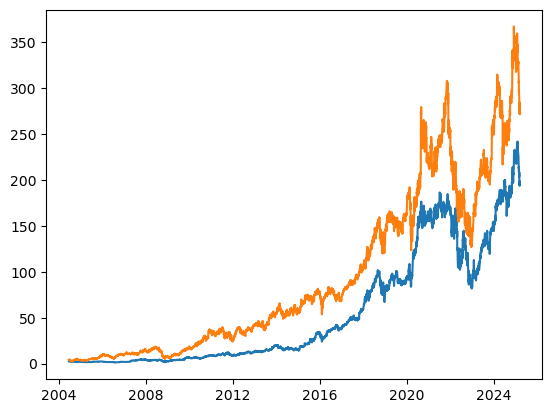

In [5]:
plt.plot(b_df)

In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Function to check cointegration
def cointegration_test(series1, series2):

    X = sm.add_constant(series1)
    model = sm.OLS(series2, X).fit()
    residuals = model.resid
    p_value = adfuller(residuals)[1]  # ADF test on residuals
    hedge_ratio = model.params[1]  # Beta coefficient (hedge ratio)
    
    return p_value, hedge_ratio, residuals

# Function to estimate Ornstein-Uhlenbeck parameters
def estimate_ou_params(spread):
    
    spread_diff = np.diff(spread)
    spread_lag = spread[:-1]
    
    # Estimate mean-reversion speed (theta) using linear regression
    theta, intercept = np.polyfit(spread_lag, spread_diff, 1)

    long_term_mean = -intercept / theta
    variance = np.var(spread_diff)
    sigma = np.sqrt(variance)
    
    return theta, long_term_mean, sigma

In [7]:
def get_hedge_ratio(A_prices, B_prices):
    B_prices = sm.add_constant(B_prices)  # Add intercept
    model = sm.OLS(A_prices, B_prices).fit()
    return model.params[1]
b_df['Hedge_Ratio'] = get_hedge_ratio( b_df[stock1] , b_df[stock2]  )

C:\Users\zig53\AppData\Local\Temp\ipykernel_10112\1402537219.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return model.params[1]


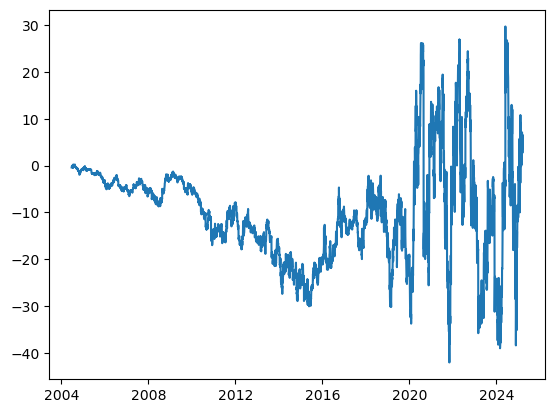

In [8]:
b_df['spread'] = b_df[f'{stock1}'] - b_df[f'{stock2}'] * b_df['Hedge_Ratio']
plt.plot(b_df['spread'])

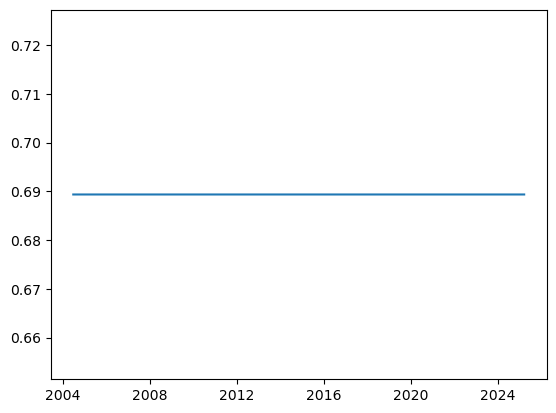

In [9]:
plt.plot( b_df['Hedge_Ratio'] )

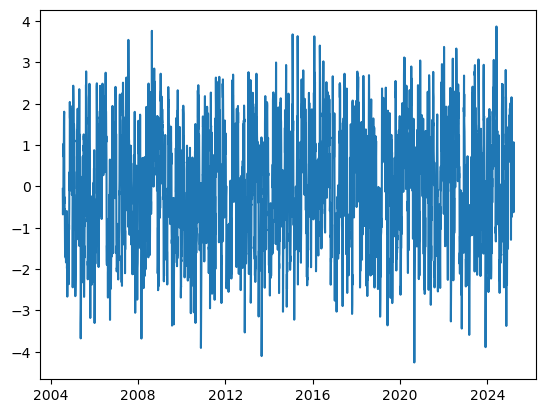

In [10]:
window = 22
b_df['z_score'] = ( b_df['spread'] - b_df['spread'].rolling(window).mean()  )/b_df['spread'].rolling(window).std()
plt.plot( b_df['z_score'] )

In [11]:
b_df['long_threshold'] = 2
b_df['short_threshold'] = -2
b_df['size_1'] = 1
b_df['size_2'] = b_df['Hedge_Ratio']
b_df.loc[ b_df['z_score'] >= b_df['long_threshold'] , 'position' ] = 1
b_df.loc[ b_df['z_score'] <= b_df['short_threshold'] , 'position' ] = -1
b_df.loc[(b_df['z_score'] > -0.5) & (b_df['z_score'] < 0.5)  , 'position' ] = 0
b_df['position'] = b_df['position'] * np.sign(b_df['Hedge_Ratio'])
b_df.loc[ ((b_df['position'] == 1) | (b_df['position'] == -1))  , 'action' ] = True
b_df.loc[ ( b_df['position'] == 0 ) , 'action' ] = False

In [12]:
# b_df = b_df[ b_df['action'] != b_df['action'].shift(1)  ]
b_df = b_df.dropna()#.reset_index()
b_df = b_df[ b_df['action'] != b_df['action'].shift(1)  ]#.reset_index(drop = True)
b_df

,AMZN,CRM,Hedge_Ratio,spread,z_score,long_threshold,short_threshold,size_1,size_2,position,action
index,,,,,,,,,,,
2004-07-23,1.9990,3.241587,0.689358,-0.235614,-0.060887,2,-2,1,0.689358,0.0,False
2004-10-07,2.0575,4.598878,0.689358,-1.112774,-2.666380,2,-2,1,0.689358,-1.0,True
2004-11-09,1.8700,4.854923,0.689358,-1.476781,-0.066252,2,-2,1,0.689358,0.0,False
2004-11-18,2.0185,4.429838,0.689358,-1.035245,2.042188,2,-2,1,0.689358,1.0,True
2004-12-22,1.9760,4.039555,0.689358,-0.808700,0.496517,2,-2,1,0.689358,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-27,205.7400,329.619028,0.689358,-21.485554,-0.295852,2,-2,1,0.689358,0.0,False
2025-01-21,230.7100,326.840000,0.689358,5.400191,2.014373,2,-2,1,0.689358,1.0,True
2025-01-27,235.4200,347.100000,0.689358,-3.856205,-0.172643,2,-2,1,0.689358,0.0,False


In [13]:
df = pd.concat( [   b_df[b_df['action'] == True].reset_index().drop( 'action' , axis = 1 ) , b_df[b_df['action'] == False].reset_index().drop( ['action','position', 'Hedge_Ratio' , 'spread' , 'z_score' , 'long_threshold' , 'short_threshold' , 'size_1' , 'size_2' ] , axis = 1 )   ]  , axis = 1 , ignore_index=False  ).dropna()
df.columns =  [ 'Entry Timestamp','ent_1' , 'ent_2' , 'hedge_ratio' , 'spread' , 'z-score' , 'long_thershold' , 'short_therhold' , 'size_1' , 'size_2' ,'position' , 'Exit Timestamp' , 'ext_1' , 'ext_2'  ]
df

,Entry Timestamp,ent_1,ent_2,hedge_ratio,spread,z-score,long_thershold,short_therhold,size_1,size_2,position,Exit Timestamp,ext_1,ext_2
0,2004-10-07,2.0575,4.598878,0.689358,-1.112774,-2.666380,2.0,-2.0,1.0,0.689358,-1.0,2004-07-23,1.9990,3.241587
1,2004-11-18,2.0185,4.429838,0.689358,-1.035245,2.042188,2.0,-2.0,1.0,0.689358,1.0,2004-11-09,1.8700,4.854923
2,2005-01-05,2.0885,4.462154,0.689358,-0.987522,-2.440983,2.0,-2.0,1.0,0.689358,-1.0,2004-12-22,1.9760,4.039555
3,2005-01-12,2.1150,3.753678,0.689358,-0.472629,2.432587,2.0,-2.0,1.0,0.689358,1.0,2005-01-10,2.0920,4.221024
4,2005-02-18,1.7655,3.964978,0.689358,-0.967790,-2.655088,2.0,-2.0,1.0,0.689358,-1.0,2005-02-03,1.7875,3.323621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,2024-09-03,176.2500,247.374128,0.689358,5.720636,2.478763,2.0,-2.0,1.0,0.689358,1.0,2024-08-20,178.8800,261.116027
184,2024-10-02,184.7600,279.148892,0.689358,-7.673556,-2.389506,2.0,-2.0,1.0,0.689358,-1.0,2024-09-19,189.8700,265.674874
185,2024-11-01,197.9300,294.370837,0.689358,-4.996928,2.816199,2.0,-2.0,1.0,0.689358,1.0,2024-10-22,189.7000,287.988407
186,2025-01-21,230.7100,326.840000,0.689358,5.400191,2.014373,2.0,-2.0,1.0,0.689358,1.0,2024-11-27,205.7400,329.619028


In [14]:
# #balance based
df = df.reset_index(drop = True)
init_bal = 1000
df['balance'] = init_bal
for col in df.columns:
    if not np.issubdtype(df[col].dtype, np.datetime64):  # Check if column is not datetime
        df[col] = df[col].astype(float)

for i in df.index :
    if i > 0 :
        
        df.loc[i,'size_1'] =  df.loc[ i-1, 'balance' ]/df.loc[ i , 'ent_1' ]
        df.loc[i,'size_2'] = df.loc[i,'size_1']* df.loc[ i , 'hedge_ratio' ]#df.loc[ i -1 , 'balance' ]/df.loc[ i , 'ent_2' ] 

        if (df.loc[ i , 'position' ] == -1)  :

            pnl = ( df.loc[i,'ext_1'] - df.loc[ i , 'ent_1' ]  ) * df.loc[i,'size_1']  + ( df.loc[ i ,  'ent_2' ] - df.loc[ i   , 'ext_2' ] ) * df.loc[i,'size_2'] #Long 1 and Short 2

            df.loc[ i , 'fee' ] = 0.25 * df.loc[i,'size_1'] * 2
            df.loc[ i , 'pnl' ] = pnl - df.loc[ i , 'fee' ]
            df.loc[ i , 'balance' ] = df.loc[ i , 'pnl' ] + df.loc[ i-1 , 'balance' ]
            df.loc[ i , 'return' ] = df.loc[ i , 'pnl' ]/df.loc[ i-1 , 'balance' ]
            
            # pnls.append( pnl )

        elif (df.loc[ i , 'position' ] == 1)  :

            pnl = ( df.loc[i,'ent_1'] - df.loc[ i , 'ext_1' ]  ) *  df.loc[i,'size_1']  + ( df.loc[ i ,  'ext_2' ] - df.loc[ i   , 'ent_2' ] ) *  df.loc[i,'size_2'] #Short 1 and Long 2
            df.loc[ i , 'fee' ] = 0.25 * df.loc[i,'size_1'] * 2
            df.loc[ i , 'pnl' ] = pnl - df.loc[ i , 'fee' ]
            df.loc[ i , 'balance' ] = df.loc[ i , 'pnl' ] + df.loc[ i-1 , 'balance' ]
            df.loc[ i , 'return' ] = df.loc[ i , 'pnl' ]/df.loc[ i-1 , 'balance' ]


    else:

        df.loc[i,'size_1'] = init_bal/df.loc[ i , 'ent_1' ]
        df.loc[i,'size_2'] =  df.loc[i,'size_1']* df.loc[ i , 'hedge_ratio' ]#init_bal/df.loc[ i , 'ent_2' ] * df.loc[ i , 'hedge_ratio' ]

        
        if (df.loc[ i , 'position' ] == -1)  :

            pnl = ( df.loc[i,'ext_1'] - df.loc[ i , 'ent_1' ]  ) * df.loc[i,'size_1']  + ( df.loc[ i ,  'ent_2' ] - df.loc[ i   , 'ext_2' ] ) * df.loc[i,'size_2']
            df.loc[ i , 'fee' ] = 0.25 * df.loc[i,'size_1'] * 2
            df.loc[ i , 'pnl' ] = pnl - df.loc[ i , 'fee' ]
            df.loc[ i , 'balance' ] = df.loc[ i , 'pnl' ] + init_bal
            df.loc[ i , 'return' ] = df.loc[ i , 'pnl' ]/init_bal


        elif (df.loc[ i , 'position' ] == 1)  :

            pnl = ( df.loc[i,'ent_1'] - df.loc[ i , 'ext_1' ]  ) *  df.loc[i,'size_1']  + ( df.loc[ i ,  'ext_2' ] - df.loc[ i   , 'ent_2' ] ) *  df.loc[i,'size_2']
            df.loc[ i , 'fee' ] = 0.25 * df.loc[i,'size_1'] * 2
            df.loc[ i , 'pnl' ] = pnl - df.loc[ i , 'fee' ]
            df.loc[ i , 'balance' ] = df.loc[ i , 'pnl' ] + init_bal
            df.loc[ i , 'return' ] = df.loc[ i , 'pnl' ]/init_bal

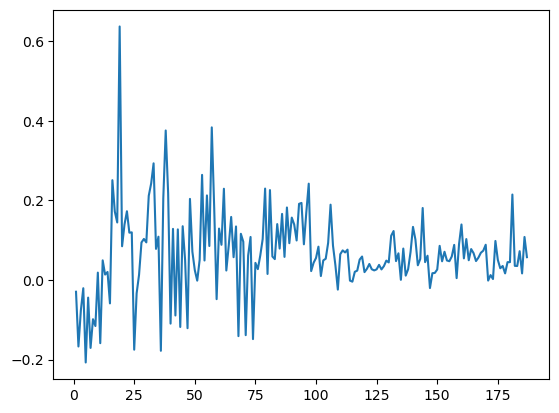

In [15]:
df['log_ret'] = np.log( df['balance'] / init_bal )
df['log_ret'] = np.log( df['balance'] / df['balance'].shift() )
plt.plot( df['log_ret'] )

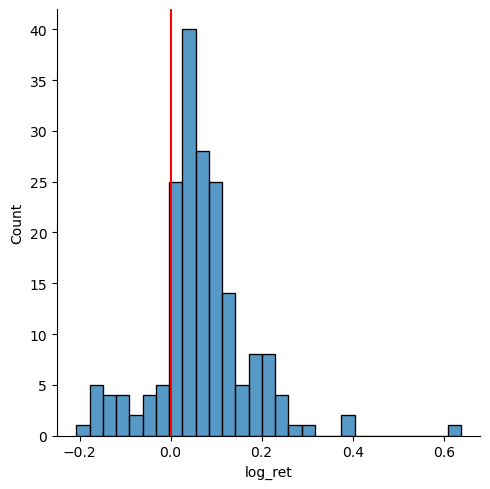

In [16]:
sns.displot(df['log_ret'], kind = 'hist' )
plt.axvline( x = 0 , color = 'red')

In [17]:
(df['log_ret']*100).describe()

count    187.000000
mean       6.713902
std       10.436903
min      -20.714080
25%        2.383871
50%        5.751749
75%       10.828476
max       63.727593
Name: log_ret, dtype: float64

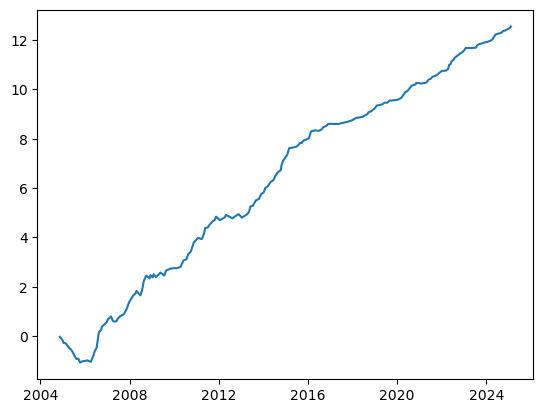

In [18]:
plt.plot( df.set_index('Entry Timestamp')['log_ret'].cumsum() )

In [19]:
win_rate = (pd.Series(df['log_ret']) > 0).mean()
win_rate

0.8457446808510638

In [20]:
expectancy = ( win_rate * df[ df['pnl'] >0  ]['pnl'].mean() ) - ( (1-win_rate) * df[ df['pnl'] <0  ]['pnl'].mean() )
expectancy

1785106.1438739419

In [21]:
(df.groupby( by = pd.to_datetime(df['Entry Timestamp']).dt.year )['log_ret'].sum( ) * 100).mean( )


57.06816398669045

In [22]:
(   df.groupby(by =  pd.to_datetime(df['Entry Timestamp']).dt.to_period("M") )['log_ret'].sum( ) * 100  ).mean( )

7.563250648838493